In [6]:
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
from dotenv import dotenv_values

from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string

In [7]:
# Load environment variables
config = dotenv_values()

# Define variables for the login
pg_user = config['POSTGRES_USER']
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

# Set up the PostgreSQL connection URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# Create the database engine
engine = create_engine(url, echo=False)
my_schema = 'capstone_barstov_industries'

# Load data directly into a DataFrame
with engine.connect() as conn:
    conn.execute(text(f'SET search_path TO {my_schema};'))
    data = pd.read_sql("SELECT * FROM model_data_week;", conn)

# Check the DataFrame structure
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172968 entries, 0 to 172967
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   product_type_no    172968 non-null  int64              
 1   product_type_name  172968 non-null  object             
 2   colour_group_code  172968 non-null  int64              
 3   colour_group_name  172968 non-null  object             
 4   week               172968 non-null  datetime64[ns, UTC]
 5   average_price      172968 non-null  float64            
 6   total_units_sold   172968 non-null  int64              
 7   unique_customers   172968 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(2)
memory usage: 10.6+ MB


In [8]:
# Inventory Sales Prediction with Ensemble Modeling
# -------------------------------------------------
# This notebook demonstrates the use of an ensemble model with Random Forest as the final estimator
# to predict weekly sales for inventory management.

# Imports
# -------
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load and Preprocess Data
# ------------------------
# Ensure 'week' is a datetime object and remove timezone information
# Convert 'week' column to datetime without timezone information
data['week'] = data['week'].dt.tz_localize(None)


# Sort data by date to ensure temporal order
data = data.sort_values(by='week')

# Feature Engineering: Creating Lagged Features for Sales
data['lag_units_sold_1week'] = data.groupby('product_type_no')['total_units_sold'].shift(1)
data['lag_units_sold_2weeks'] = data.groupby('product_type_no')['total_units_sold'].shift(2)

# Drop rows with NaN values created by lagging (occurs at the beginning of each product group)
data = data.dropna(subset=['lag_units_sold_1week', 'lag_units_sold_2weeks']).reset_index(drop=True)

# Adding Cyclic Encoding for Weeks
data['week_of_year'] = data['week'].dt.isocalendar().week
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

# Train-Validation-Test Split with Date Ranges
# --------------------------------------------

# Define the end date as the maximum date in the dataset
end_date = data['week'].max()

# Define date ranges for train, validation, and test
train_end_date = end_date - pd.Timedelta(weeks=8)  # End training 6 weeks before the end date
validation_start_date = train_end_date + pd.Timedelta(weeks=4)  # Start validation 2 weeks after training ends
validation_end_date = end_date - pd.Timedelta(weeks=4)  # End validation 4 weeks before the end date

# Split data into train, validation, and test sets based on specific date ranges
train_data = data[data['week'] <= train_end_date]
validation_set = data[(data['week'] > train_end_date) & (data['week'] <= validation_end_date)]
test_set = data[data['week'] > validation_end_date]

# Define features and target variable
feature_columns = ['product_type_no', 'colour_group_code', 'average_price', 
                   'lag_units_sold_1week', 'lag_units_sold_2weeks', 'week_sin', 'week_cos']

X_train = train_data[feature_columns]
y_train = train_data['total_units_sold']

X_validation = validation_set[feature_columns]
y_validation = validation_set['total_units_sold']

X_test = test_set[feature_columns]
y_test = test_set['total_units_sold']

# Confirm the split date ranges
print("Training Date Range:", train_data['week'].min(), "to", train_data['week'].max())
print("Validation Date Range:", validation_set['week'].min(), "to", validation_set['week'].max())
print("Test Date Range:", test_set['week'].min(), "to", test_set['week'].max())

# Initialize and Train Base Models
# -------------------------------
model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
model_lr = LinearRegression()
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Fit each base model on the training data
model_rf.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

# Generate predictions for the validation set from each model
preds_rf = model_rf.predict(X_validation)
preds_lr = model_lr.predict(X_validation)
preds_mlp = model_mlp.predict(X_validation)

# Create a new DataFrame to hold the base model predictions
predictions_df = pd.DataFrame({
    'RandomForest': preds_rf,
    'LinearRegression': preds_lr,
    'MLPRegressor': preds_mlp
})

# Final Meta-Model Using Random Forest
# ------------------------------------
final_model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
final_model_rf.fit(predictions_df, y_validation)

# Final Predictions and Evaluation
# --------------------------------
final_preds_rf = final_model_rf.predict(predictions_df)

# Evaluate the Random Forest final model on validation set
mae_rf = mean_absolute_error(y_validation, final_preds_rf)
rmse_rf = mean_squared_error(y_validation, final_preds_rf, squared=False)

print("Ensemble with Random Forest as Final Model - MAE:", mae_rf)
print("Ensemble with Random Forest as Final Model - RMSE:", rmse_rf)

# Feature Importance Analysis (for the final model)
# -------------------------------------------------
print("Feature importances from the final meta-model:", final_model_rf.feature_importances_)


Training Date Range: 2018-09-16 22:00:00 to 2020-07-26 22:00:00
Validation Date Range: 2020-08-02 22:00:00 to 2020-08-23 22:00:00
Test Date Range: 2020-08-30 22:00:00 to 2020-09-20 22:00:00
Ensemble with Random Forest as Final Model - MAE: 32.871849780373445
Ensemble with Random Forest as Final Model - RMSE: 107.43224567622283
Feature importances from the final meta-model: [0.9029339  0.04933685 0.04772925]


/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [18]:
# Group by 'week' and calculate the total units sold per week
weekly_sales = data.groupby('week')['total_units_sold'].sum()

# Calculate the average units sold per week across all weeks
average_units_sold_per_week = weekly_sales.mean()

# Display the result
print("Average units sold per week:", average_units_sold_per_week)


Average units sold per week: 270423.8396226415


In [24]:
# Aggregate total units sold by week
weekly_sales = data.groupby('week')['total_units_sold'].sum()

# Calculate the range of weekly sales
weekly_sales_min = weekly_sales.min()
weekly_sales_max = weekly_sales.max()

print("Minimum weekly units sold:", weekly_sales_min)
print("Maximum weekly units sold:", weekly_sales_max)



Minimum weekly units sold: 58371
Maximum weekly units sold: 508779



| Meta-Model            | MAE       | RMSE     |
|-----------------------|-----------|----------|
| **Random Forest**     | 30.91     | 109.64   |
| **MLP Regressor**     | 76.19     | 239.57   |
| **Linear Regression** | 78.75     | 243.82   |

### Interpretation

- **Random Forest as Best Choice**: The Random Forest clearly outperforms both MLP and Linear Regression as a meta-model, achieving much lower error metrics.
- **Higher Errors with MLP and Linear Regression**: Both MLP and Linear Regression show similar MAE and RMSE, but these metrics are higher than those of the Random Forest, indicating that they may not capture the nuances of the base models’ predictions as effectively.

### Conclusion

Based on these results, **Random Forest is the most effective choice for your ensemble’s meta-model**. It provides the lowest MAE and RMSE, making it a strong candidate for your predictive needs.


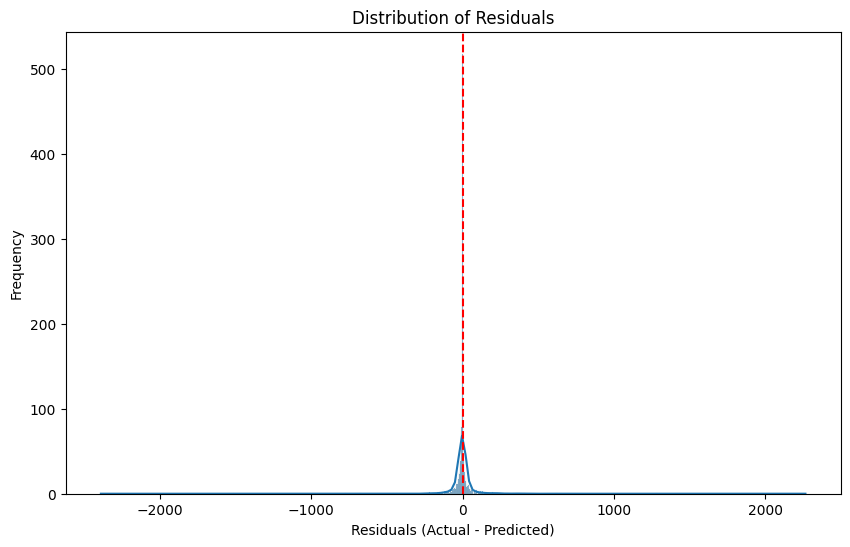

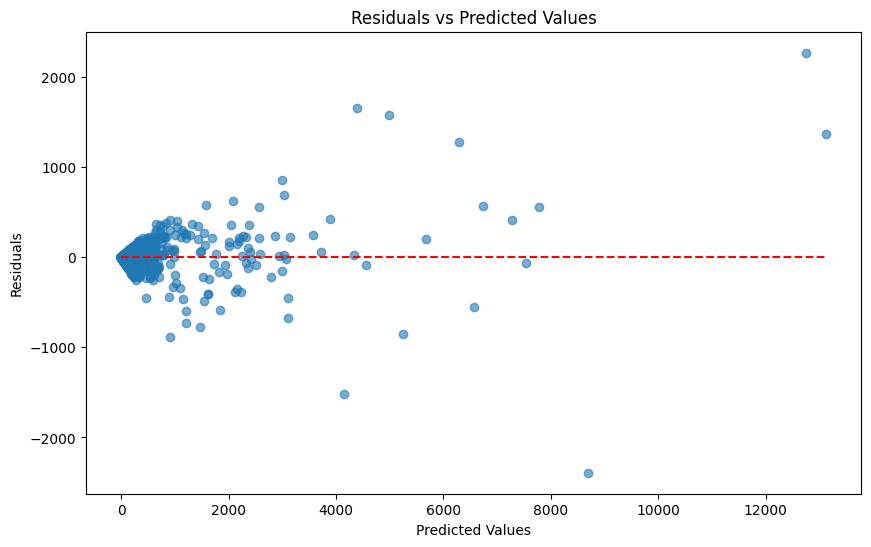

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals on the validation set
residuals = y_validation - final_preds_rf  # final_preds_rf are the predictions from the Random Forest meta-model

# Plot Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Plot Residuals vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(final_preds_rf, residuals, alpha=0.6)
plt.hlines(0, xmin=final_preds_rf.min(), xmax=final_preds_rf.max(), colors='red', linestyles='--')
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Ensure 'week' is in datetime format without timezone
data['week'] = pd.to_datetime(data['week']).dt.tz_localize(None)

# Sort data by product type, color, and date to ensure proper lagging
data = data.sort_values(by=['product_type_no', 'colour_group_code', 'week'])

# Feature Engineering: Lagged Features
data['lag_units_sold_1week'] = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].shift(1)
data['lag_units_sold_2weeks'] = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].shift(2)
data = data.dropna(subset=['lag_units_sold_1week', 'lag_units_sold_2weeks']).reset_index(drop=True)

# Cyclic Encoding for Weeks
data['week_of_year'] = data['week'].dt.isocalendar().week
data['week_sin'] = np.sin(2 * np.pi * data['week_of_year'] / 52)
data['week_cos'] = np.cos(2 * np.pi * data['week_of_year'] / 52)

# Define the last week in the dataset and prepare training and validation sets
latest_week = data['week'].max()
train_data = data[data['week'] < latest_week]  # All data except the last week
last_week_data = data[data['week'] == latest_week]  # The last week (validation)

# Define feature columns
feature_columns = ['product_type_no', 'colour_group_code', 'average_price', 
                   'lag_units_sold_1week', 'lag_units_sold_2weeks', 'week_sin', 'week_cos']

X_train = train_data[feature_columns]
y_train = train_data['total_units_sold']

X_validation = last_week_data[feature_columns]
y_validation = last_week_data['total_units_sold']

# Initialize base models
model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
model_lr = LinearRegression()
model_mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Train each base model
model_rf.fit(X_train, y_train)
model_lr.fit(X_train, y_train)
model_mlp.fit(X_train, y_train)

# Generate predictions for the last week from each base model
preds_rf = model_rf.predict(X_validation)
preds_lr = model_lr.predict(X_validation)
preds_mlp = model_mlp.predict(X_validation)

# Combine base model predictions
last_week_predictions_df = pd.DataFrame({
    'RandomForest': preds_rf,
    'LinearRegression': preds_lr,
    'MLPRegressor': preds_mlp
})

# Use a meta-model (e.g., RandomForest) trained previously as the final model
final_model_rf = RandomForestRegressor(n_estimators=200, max_depth=30, random_state=42)
final_model_rf.fit(last_week_predictions_df, y_validation)  # Fit the meta-model with validation predictions

# Predict inventory needs for the last week
final_preds = final_model_rf.predict(last_week_predictions_df)

# Add predictions to last week's data
last_week_data['predicted_units_sold'] = final_preds

# Calculate metrics for validation
mae = mean_absolute_error(y_validation, final_preds)
rmse = mean_squared_error(y_validation, final_preds, squared=False)
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)

# Aggregate inventory needs by product type and color for the last week
inventory_needs = last_week_data.groupby(['product_type_no', 'colour_group_code'])['predicted_units_sold'].sum().reset_index()
inventory_needs.columns = ['product_type_no', 'colour_group_code', 'predicted_inventory_needs']

# Display inventory needs
print(inventory_needs)


Validation MAE: 3.122518549051937
Validation RMSE: 16.716619574913047
      product_type_no  colour_group_code  predicted_inventory_needs
0                  -1                  6                     14.745
1                  -1                  7                     26.080
2                  -1                  8                      4.150
3                  -1                  9                    330.760
4                  -1                 10                    168.745
...               ...                ...                        ...
1208              529                 31                      3.930
1209              529                 51                     11.500
1210              529                 52                      3.015
1211              529                 61                      5.530
1212              532                  9                      3.665

[1213 rows x 3 columns]


/var/folders/4d/qdk_qyjn1ng60t10crv82wj00000gn/T/ipykernel_80646/304248778.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_week_data['predicted_units_sold'] = final_preds
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
# Extract unique mappings from data for product type and color group
product_type_mapping = data[['product_type_no', 'product_type_name']].drop_duplicates()
colour_group_mapping = data[['colour_group_code', 'colour_group_name']].drop_duplicates()


In [13]:
# Merge product type names
inventory_needs = inventory_needs.merge(product_type_mapping, on='product_type_no', how='left')

# Merge colour group names
inventory_needs = inventory_needs.merge(colour_group_mapping, on='colour_group_code', how='left')


In [14]:
# Reorder columns for clarity
inventory_needs = inventory_needs[['product_type_no', 'product_type_name', 'colour_group_code', 'colour_group_name', 'predicted_inventory_needs']]


In [15]:
print(inventory_needs)


      product_type_no product_type_name  colour_group_code colour_group_name  \
0                  -1           Unknown                  6        Light Grey   
1                  -1           Unknown                  7              Grey   
2                  -1           Unknown                  8         Dark Grey   
3                  -1           Unknown                  9             Black   
4                  -1           Unknown                 10             White   
...               ...               ...                ...               ...   
1208              529       Mobile case                 31      Light Orange   
1209              529       Mobile case                 51        Light Pink   
1210              529       Mobile case                 52              Pink   
1211              529       Mobile case                 61      Light Purple   
1212              532          Umbrella                  9             Black   

      predicted_inventory_needs  
0    

In [16]:
# Set up the schema if needed and push inventory_needs to PostgreSQL
with engine.connect() as conn:
    conn.execute(text(f'SET search_path TO {my_schema};'))
    inventory_needs.to_sql('inventory_needs', con=engine, schema=my_schema, if_exists='replace', index=False)

print("Inventory needs table successfully pushed to the database!")


Inventory needs table successfully pushed to the database!


In [17]:
# Calculate the total predicted inventory needs
total_inventory_needs = inventory_needs['predicted_inventory_needs'].sum()
print("Total Predicted Inventory Needs:", total_inventory_needs)


Total Predicted Inventory Needs: 57349.91499999999


count    1213.000000
mean       47.279402
std       172.949883
min         1.000000
25%         2.240000
50%         7.160000
75%        27.125000
max      3034.665000
Name: predicted_inventory_needs, dtype: float64


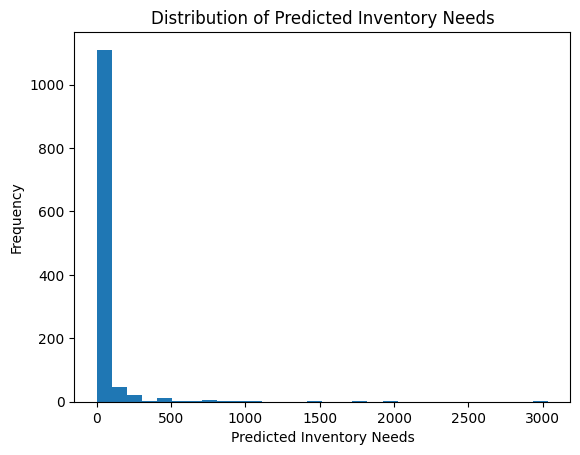

In [18]:
# Summary statistics of the predictions
print(inventory_needs['predicted_inventory_needs'].describe())

# Optional: Plot histogram to visually inspect the distribution
import matplotlib.pyplot as plt

plt.hist(inventory_needs['predicted_inventory_needs'], bins=30)
plt.xlabel('Predicted Inventory Needs')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Inventory Needs')
plt.show()


In [19]:
# If you have actuals for the validation week:
actual_total = y_validation.sum()
predicted_total = inventory_needs['predicted_inventory_needs'].sum()
print("Actual Total Units Sold (Validation Week):", actual_total)
print("Predicted Total Inventory Needs (Validation Week):", predicted_total)


Actual Total Units Sold (Validation Week): 58177
Predicted Total Inventory Needs (Validation Week): 57349.91499999999


In [21]:
# Calculate historical average units sold for each product type and color
historical_avg = data.groupby(['product_type_no', 'colour_group_code'])['total_units_sold'].mean().reset_index()
historical_avg.columns = ['product_type_no', 'colour_group_code', 'historical_avg_units_sold']


In [22]:
# Merge historical averages with inventory_needs to compare predictions with historical data
inventory_needs = inventory_needs.merge(historical_avg, on=['product_type_no', 'colour_group_code'], how='left')


In [23]:
# Calculate a scaling factor based on total historical vs. total predicted
historical_total = historical_avg['historical_avg_units_sold'].sum()
predicted_total = inventory_needs['predicted_inventory_needs'].sum()
scaling_factor = historical_total / predicted_total if predicted_total != 0 else 1

# Apply scaling factor to predictions
inventory_needs['scaled_predicted_inventory_needs'] = inventory_needs['predicted_inventory_needs'] * scaling_factor
print("Total Scaled Predicted Inventory Needs:", inventory_needs['scaled_predicted_inventory_needs'].sum())


Total Scaled Predicted Inventory Needs: 279460.37052368734
